<img width="100" src="https://carbonplan-assets.s3.amazonaws.com/monogram/dark-small.png" style="margin-left:0px;margin-top:20px"/>

Forest Emissions Tracking - Phase I
===================================

_by Joe Hamman and Jeremy Freeman (CarbonPlan)_

March 29, 2020

## Introduction
In general, greenhouse gasses (GHGs) arising from forest land use changes can be attributed to both natural factors (e.g. wildfire) and human activities (e.g. deforestation). Our approach is to build upon an existing body of research that has provided high-resolution satellite-based estimates of aboveground biomass (Spawn et al., 2020), forest cover change (Hansen et al., 2013), and change attribution (Curtis et al., 2018). While many of the necessary data products already exist, we can integrate, extend, or update these resources to provide global, current estimates that can be integrated with the other resources produced by the coalition.

Specifically, for any given spatial extent and time duration ($t1$ to $t2$), we can use three quantities — existing biomass, forest cover change, and change attribution — to estimate the effective GHG emissions from land use changes. The simplest estimate is:

$\Delta Biomass (t) = TotalBiomass (t) * \Delta ForestCover (\%)$

$Emissions (tCO_2) = \Delta Biomass (t) * 0.5 (tC/t) * 3.67 (tC02 / tC)$

where $\Delta ForestCover$ is the fraction of pixels within the given spatial extent that experienced a stand-replacement disturbance between $t1$ and $t2$. The $TotalBiomass$ is estimated as the aboveground biomass at time $t1$. This estimate can be further refined by attributing, for each pixel, the source of forest cover loss (e.g. wildfire, deforestation, etc.), and using those sources to express emissions fractionally and/or exclude certain categories from total estimates (e.g. rotational clear-cutting within tree plantations). Pixel-wise estimates can then be aggregated into province and country-wide estimates.

## Setup

To begin, we'll import a handful of Python libraries and set a few constants.

In [1]:
1+2

3

In [44]:
%matplotlib inline
import dask
import intake
import xarray as xr
from tqdm import tqdm
import numcodecs


TC02_PER_TC = 3.67
TC_PER_TBM = 0.5
SQM_PER_HA = 10000
ORNL_SCALING = 0.1

In [46]:
from dask_gateway import Gateway

gateway = Gateway()
options = gateway.cluster_options()
options.worker_cores = 2
options.worker_memory = 24
cluster = gateway.new_cluster(cluster_options=options)
cluster.adapt(minimum=1, maximum=300)
cluster


In [47]:
client = cluster.get_client()
client

Client Scheduler: gateway://traefik-gcp-us-central1-b-prod-dask-gateway.prod:80/prod.f3260a488dee4052b05fe91119f728dd Dashboard: https://gcp-us-central1b.hub.carbonplan.org/services/dask-gateway/clusters/prod.f3260a488dee4052b05fe91119f728dd/status,Cluster Workers: 1 Cores: 2 Memory: 25.77 GB


In [48]:
# data catalog
cat = intake.open_catalog("https://raw.githubusercontent.com/carbonplan/forest-emissions-tracking/master/catalog.yaml")

In [57]:
import fsspec

with fsspec.open('https://storage.googleapis.com/earthenginepartners-hansen/GFC-2018-v1.6/treecover2000.txt') as f:
    lines = f.read().decode().splitlines() 
print(len(lines))
    
# americas tiles
americas_lats = ['20N']# ['60N', '50N', '40N', '30N', '20N', '10N', '00N',
             #'10S', '20S', '30S', '40S', '50S', '60S']
americas_lons = ['110W', '100W'] #['140W', '130W', '120W', '110W', '100W', # these ones were already done
#             '090W', '080W', '070W', '060W', '050W', '040W']

# all tiles
lats = []
lons = []
for line in lines:
    pieces = line.split('_')
    lat = pieces[-2]
    lon = pieces[-1].split('.')[0]
    
    if (lat in americas_lats) and (lon in americas_lons):
        lats.append(lat)
        lons.append(lon)
print(len(lats))

504
2


In [51]:
def _preprocess(da, lat=None, lon=None):
    da = da.rename({"x": "lon", "y": "lat"}).squeeze(drop=True)
    if lat is not None:
        da = da.assign_coords(lat=lat, lon=lon)
    return da


def open_hansen_2018_tile(lat, lon, emissions=False):
    ds = xr.Dataset()

    # Min Hansen data
    variables = ["treecover2000", "gain", "lossyear", "datamask"] #, "first", "last"]
    for v in variables:
        da = cat.hansen_2018(variable=v, lat=lat, lon=lon).to_dask().pipe(_preprocess)
        # force coords to be identical
        if ds:
            da = da.assign_coords(lat=ds.lat, lon=ds.lon)
        ds[v] = da

    ds["treecover2000"] /= 100.0
    ds["lossyear"] += 2000

    # Hansen biomass
    ds["agb"] = (
        cat.hansen_biomass(lat=lat, lon=lon).to_dask().pipe(_preprocess, lat=ds.lat, lon=ds.lon)
    )
    if emissions:
        # Hansen emissions
        ds["emissions_ha"] = (
            cat.hansen_emissions_ha(lat=lat, lon=lon)
            .to_dask()
            .pipe(_preprocess, lat=ds.lat, lon=ds.lon)
        )
        ds["emissions_px"] = (
            cat.hansen_emissions_px(lat=lat, lon=lon)
            .to_dask()
            .pipe(_preprocess, lat=ds.lat, lon=ds.lon)
        )

    return ds

In [58]:
# open a single 10x10degree tile of the Hansen 30x30m data
lat = lats[1]
lon = lons[1]
box = dict(lat=slice(0, 40000, 100), lon=slice(0, 40000, 100))

ds = open_hansen_2018_tile(lat, lon)
display(ds)

<xarray.Dataset>
Dimensions:        (lat: 40000, lon: 40000)
Coordinates:
  * lat            (lat) float64 20.0 20.0 20.0 20.0 ... 10.0 10.0 10.0 10.0
  * lon            (lon) float64 -110.0 -110.0 -110.0 ... -100.0 -100.0 -100.0
Data variables:
    treecover2000  (lat, lon) float64 dask.array<chunksize=(4000, 4000), meta=np.ndarray>
    gain           (lat, lon) uint8 dask.array<chunksize=(4000, 4000), meta=np.ndarray>
    lossyear       (lat, lon) uint16 dask.array<chunksize=(4000, 4000), meta=np.ndarray>
    datamask       (lat, lon) uint8 dask.array<chunksize=(4000, 4000), meta=np.ndarray>
    agb            (lat, lon) int16 dask.array<chunksize=(4000, 4000), meta=np.ndarray>

In [53]:
import numpy as np
np.nonzero(ds.treecover2000).mean()

<xarray.DataArray 'treecover2000' ()>
array(4750482020221)

In [59]:
encoding = {'emissions': {'compressor': numcodecs.Blosc()}}

In [62]:
def calc_emissions(ds):
    d_biomass = ds['agb'] * ds['d_treecover']
    emissions = d_biomass * TC_PER_TBM * TC02_PER_TC
    return emissions


def calc_one_tile(ds):
    # calculate d_treecover
    years = xr.DataArray(range(2001, 2019), dims=('year', ), name='year')
    loss_frac = []
    for year in years:
        loss_frac.append(xr.where((ds['lossyear'] == year), ds['treecover2000'], 0))
    ds['d_treecover'] = xr.concat(loss_frac, dim=years)
    ds['emissions'] = calc_emissions(ds)
    return ds


@dask.delayed
def process_one_tile(lat, lon):
    url = f'gs://carbonplan-scratch/global-forest-emissions/{lat}_{lon}.zarr'
    
    if '.zmetadata' in url:
        # skip - dataset is already complete
        return url
    mapper = fsspec.get_mapper(url)

    with dask.config.set(scheduler='threads'):
        ds = open_hansen_2018_tile(lat, lon)
        ds = calc_one_tile(ds)[['emissions']]
        ds = ds.chunk({'lat': 4000, 'lon': 4000, 'year': 2})
        ds.to_zarr(mapper, encoding=encoding, mode='w')
        return url

In [63]:
rerun_tiles = True
if rerun_tiles:
    tiles = []
    for lat, lon in tqdm(list(zip(lats, lons))):
        tiles.append(client.persist(process_one_tile(lat, lon), retries=1))

100%|██████████| 2/2 [00:00<00:00, 280.93it/s]


In [65]:
from itertools import product
americas_tiles = list(product(americas_lats, americas_lons)

Next, we'll load each of the tiles from above, coarsen them 100-fold in each direction (by summing emissions spatially), and then mosaic all the tiles together into a single xr dataset. Two notes for this step. First, it gets a little funky if you're running using a client/cluster. So, it might be worth your time to just power down your cluster and run this on a single machine that you have for this notebook. It'll run slower but your skull might be a little less bruised from banging your head against the wall. Second, you'll get a bunch of failed tiles below due to ocean cells that don't have active tiles. That's great and normal. Bask in the glory of the the NaNs that will fill that space!

In [84]:
recombine=False
if recombine:
    conus_ds_all_tiles = []
    for lat, lon in tqdm(americas_tiles):
        try:
            conus_ds_all_tiles.append(xr.open_zarr(f'gs://carbonplan-scratch/global-forest-emissions/{lat}_{lon}.zarr'.format()).coarsen(lat=100, lon=100).sum().compute()#,
    #                                           chunks={'lat': 1000,
    #                                     'lon': 1000}),
                                 )
        except:
            print('{} {} didnt work booooo'.format(lat, lon))

Then combine that whole list into a single dataset and write it out.

In [89]:
coarsened_url = f'gs://carbonplan-scratch/global-forest-emissions/americas/3000m/raster.zarr'
mapper = fsspec.get_mapper(coarsened_url)


if recombine:
    # with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    combined_ds = xr.combine_by_coords(conus_ds_all_tiles, 
                                             compat='override',
                                            coords='minimal')
    combined_ds.to_zarr(mapper, 
                     encoding=encoding, 
                     mode='w')
else:
    combined_ds = xr.open_zarr(mapper)
    combined_ds = combined_ds.rename({'emissions': 'Emissions [tC02/year]'})

Then we'll load all of these back into a single array and concatenate along the year dimension.

# Sanity checks!

Let's take a look at the dataset and get a handle on whether this makes sense. Let's do it by looking at a handful of big fires as a gut check for biomass loss.

First let's check out the Thomas Fire in Santa Barbara in 2017, the second largest (outside of 2020) California history
since we don't have 2020 data yet. This ranking is according to wikipedia - https://en.wikipedia.org/wiki/List_of_California_wildfires. I include this because there's a narrative here - we're on a Sherlock Holmes level hunt for fires. Using satellite biomass data as our clues!

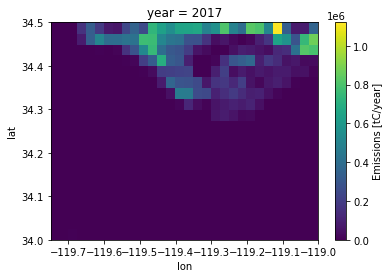

In [37]:
santa_barbara = combined_ds.sel(lat=slice(34,34.5), lon=slice(-119.75, -119))['Emissions [tC02/year]']
santa_barbara.sel(year=2017).plot()

But then let's see how that fire compared to years previous. It turns out that, indeed, it was a big one, burning over 40 megatons of biomass in 2017. Some of that fire carried over into 2018 too.

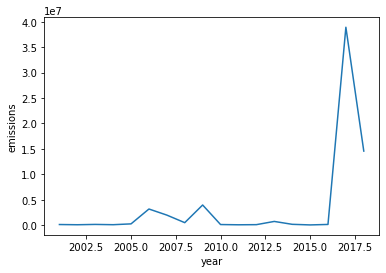

In [124]:
santa_barbara.sum(dim=['lat', 'lon']).plot()

Out of curiosity, we can take a look at a slightly bigger box, extending further north. When we do that, we notice that the 2017 Thomas Fire was actually dwarfed by something in 2007. What is this aberration!? I thought wikipedia, the paragon of truth, told us that the Thomas Fire was the biggest!

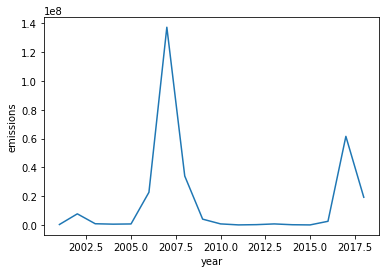

In [132]:
santa_barbara_bigger = combined_ds.sel(lat=slice(34,35), lon=slice(-119.75, -119))
santa_barbara_bigger.sum(dim=['lat', 'lon']).plot()

Turns out that actually there was *giant* complex of fires (also in Santa Barbara county) in 2007. Over a million acres burned. And they were picked up by the loss in biomass. So this is some rejection of bias on my end! Excellent. 

Let's go check somewhere else just to see if it's working elsewhere. Let's travel up to my home state of Washington State. As a gut check, the 2015 fire season was the largest in recent memory. Let's see if it jumps out at all in total Washington losses.

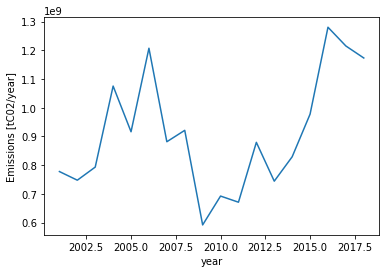

In [91]:
washington_state = combined_ds.sel(lat=slice(45.5,49), lon=slice(-124.6, -117))['Emissions [tC02/year]']
washington_state.sum(dim=['lat', 'lon']).plot()

Well, let's take a look at the Okanaogan region where they had a giant fire in 2015. So, let's see if zooming in a little further into specific regions of big fires leap out. 

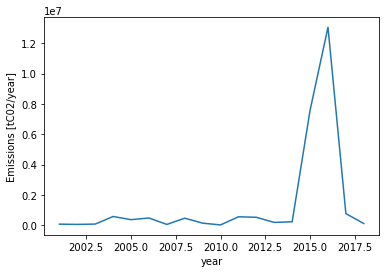

In [112]:
washington_state.sel(lat=slice(48.4,48.6), lon=slice(-119.8, -119.6)).sum(dim=['lat', 'lon']).plot()

Now let's check out Brazil. First we can look at the state of Mato Grosso, one site of heavy deforestation for conversion to agriculure.

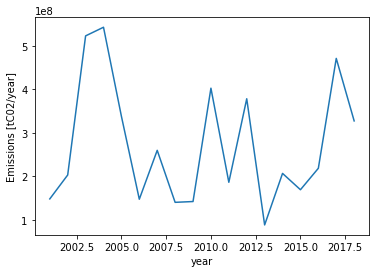

In [124]:
combined_ds.sel(lat=slice(-14, -11), lon=slice(-55,-54)).sum(dim=['lat', 'lon'])['Emissions [tC02/year]'].plot()

Then we can switch to the state of Pará.

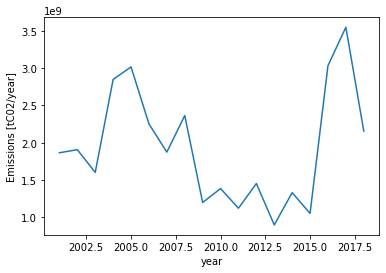

In [125]:
combined_ds.sel(lat=slice(-9, -2), lon=slice(-54,-49)).sum(dim=['lat', 'lon'])['Emissions [tC02/year]'].plot()

Selecting a year we can see individual plots of land where mass deforestation has occurred.

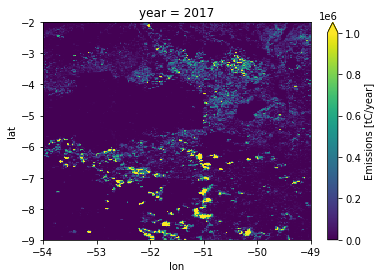

In [43]:
combined_ds.sel(lat=slice(-9, -2), lon=slice(-54,-49)).sel(year=2017)['Emissions [tC02/year]'].plot(vmax=1e6)

# Gutcheck by trying to reproduce Zarin et al (2016)
## a.k.a. Reproducibility Rumble

Now let's try to reproduce a figure from Zarin et al (2016). We'll try out Mexico since we can reasonably easily select a box around all of Mexico without including other countries. We include Guatemala and a bit of Southern Texas/Arizona but let's just assume those are negligible compared to the country of Mexico. So, comparing this to the plot from 

In [103]:
mexico = combined_ds.sel(lat=slice(14,31), lon=slice(-117,-87))

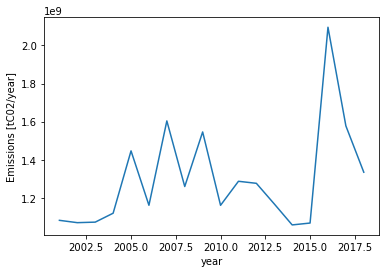

In [111]:
mexico.sum(dim=['lat', 'lon'])['Emissions [tC02/year]'].plot()

SAD FACE! We're off by a _ton_ <--- a pun! because we're talking about tons of carbon!! :grin:

our estimates are off by a factor of ~100. now, zarin's plot for mexico only includes deforestation, (so maybe that excludes the fire-attributed losses?). But they're def off by orders of magnitude. maybe these estimates we're calculating by combining everything is actually spatially-averaged quantities - tCO2/hectare. which would mean that an average is really what we want. and that coarsening isn't quite right because the geographic transformation matters. nevertheless, i think the coarsening effect might be okay as an approximation for now.

HOWEVER, the per hectare unit thing is an issue- we summed things to go from 30m-->3km, so we'd need to divide them by ~10000 (to account for the coarsening 100-fold in each direction) to get back to the per hectare unit. and then we use that per hectare unit and average it across regions and multiply by the hectare area to get the right tCO2. as a gut check i applied that "divide by 10,000" correction that around my bounding box for mexico, multiplied it by mexico's area (in hectares) and the units are on the same order of magnitude of zarin. now, this is very back-of-the-envelope. but i think it makes sense! so, for reporting values, each of our coarsened pixels just needs to be divided by 10,000 and then scaled by how many hectares that pixel is (which decreases going away from the equator, but we could make a raster of that).

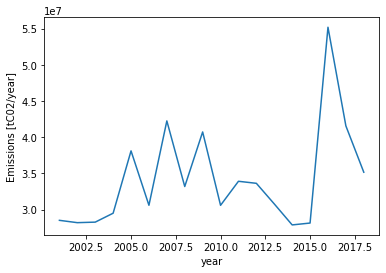

In [109]:
hectares_in_mexico = 197253494
correction_for_having_summed_during_coarsening = 100 * 100
(mexico.mean(dim=['lat', 'lon'])*hectares_in_mexico/correction_for_having_summed_during_coarsening)['Emissions [tC02/year]'].plot()

ba da bing ba da boom! Now we're in the ballpark of Zarin. Don't miss the next episode, when we figure out why our wiggles are totally off from theirs.... tune in!

In [83]:
client.close()
cluster.close()